# Problem 5   

#### Link to github :    
#### https://github.com/HugoCote/Assignment2-Part3    
#### Authors :     
Srinivas Venkattaramanujam,    
Jean-Philippe Gagnon-Fleury,    
Hugo Côté,     
Ahmadreza Godarzvandchegini    

This file contains the code to collect, save and load the data required to answer problem 5.1, 5.2 and 5.3. The data must be located to specific local directories in order to be loaded. For all 3 problems, everything has been previously runned. The data only has to be loaded and answers to each questions immediately follow.

In [244]:
# 
import argparse
import time
import collections
import os
import sys
import copy

#
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn

#
import matplotlib.pyplot as plt 

# 
import models
from models import make_model as TRANSFORMER

#### Set the device

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Code taken from ptb-lm.py

In [839]:
# HELPER FUNCTIONS
def _read_words(filename):
    with open(filename, "r") as f:
      return f.read().replace("\n", "<eos>").split()

def _build_vocab(filename):
    data = _read_words(filename)

    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    id_to_word = dict((v, k) for k, v in word_to_id.items())

    return word_to_id, id_to_word

def _file_to_word_ids(filename, word_to_id):
    data = _read_words(filename)
    return [word_to_id[word] for word in data if word in word_to_id]

# Processes the raw data from text files
def ptb_raw_data(data_path=None, prefix="ptb"):
    train_path = os.path.join(data_path, prefix + ".train.txt")
    valid_path = os.path.join(data_path, prefix + ".valid.txt")
    test_path  = os.path.join(data_path, prefix + ".test.txt")

    word_to_id, id_2_word = _build_vocab(train_path)
    train_data = _file_to_word_ids(train_path, word_to_id)
    valid_data = _file_to_word_ids(valid_path, word_to_id)
    test_data  = _file_to_word_ids(test_path , word_to_id)
    return train_data, valid_data, test_data, word_to_id, id_2_word

# Yields minibatches of data
def ptb_iterator(raw_data, batch_size, num_steps):
    raw_data = np.array(raw_data, dtype=np.int32)

    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)
    for i in range(batch_size):
        data[i] = raw_data[batch_len * i:batch_len * (i + 1)]

    epoch_size = (batch_len - 1) // num_steps

    if epoch_size == 0:
        raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

    for i in range(epoch_size):
        x = data[:, i*num_steps:(i+1)*num_steps]
        y = data[:, i*num_steps+1:(i+1)*num_steps+1]
        yield (x, y)

def repackage_hidden(h):
    if isinstance(h, Variable):
        return h.detach_()
    else:
        return tuple(repackage_hidden(v) for v in h)

class Batch:
    "Data processing for the transformer. This class adds a mask to the data."
    def __init__(self, x, pad=0):
        self.data = x
        self.mask = self.make_mask(self.data, pad)

    @staticmethod
    def make_mask(data, pad):
        "Create a mask to hide future words."

        def subsequent_mask(size):
            """ helper function for creating the masks. """
            attn_shape = (1, size, size)
            subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
            return torch.from_numpy(subsequent_mask) == 0

        mask = (data != pad).unsqueeze(-2)
        mask = mask & Variable(
            subsequent_mask(data.size(-1)).type_as(mask.data))
        return mask

# Prob 5.1

The relevant code for this problem is located in problem5.py -> code_for_51. 
We first instantiate and load a trained model (in problem 4.1) to collect the required data. For the RNN and the GRU we run the model on the validation sequence 2 times, each time computing the loss function at each time step and averaging it across sequence of the same batch, then averaging the result across all the batches. The first time, we re-initialize the hidden state at the beginning of each new batch, the second time we only initialize it at the start of an epoch. For the transformer, there is no hidden state and we only run it once to compute the average loss per time step.

The code below runs a single model (RNN, GRU or TRANSFORMER) on the validation dataset and save the results to a .npy file that can be loaded afterwards to compare the result for different architechture. You can choose the model and choose if you want to re-initialize the hidden states for each new batch.

In [310]:
# step 1 , instantiate a model.

import importlib
import problem5
importlib.reload(problem5)
import models_coop as modelsc
importlib.reload(modelsc)
import matplotlib.cm as cm

# model_type = 'RNN'
# model_type = 'GRU'
model_type = 'TRANSFORMER'

n_units      = 512
hidden_size  = 1500
emb_size     = 200
seq_len      = 35
batch_size   = 20
vocab_size   = 10000
num_layers   = 2
dp_keep_prob = 0.35
dp_prob_tran = 0.1
num_blocks   = 6

datapath  = "./from_teacher/data"
print('Loading data from '+ datapath)
raw_data = ptb_raw_data(data_path=datapath)
train_data, valid_data, test_data, word_to_id, id_2_word = raw_data
vocab_size = len(word_to_id)

if model_type == 'RNN':
    net = modelsc.RNN(emb_size=emb_size, hidden_size=hidden_size,
                seq_len=seq_len, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers,
                dp_keep_prob=dp_keep_prob)
    loading_path = "RNN_final"
    loading_path += "/best_params.pt"
    net.load_state_dict(torch.load(loading_path))
elif model_type == 'GRU':
    net = modelsc.GRU(emb_size=emb_size, hidden_size=hidden_size,
                seq_len=seq_len, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers,
                dp_keep_prob=dp_keep_prob)
    loading_path = "GRU_final"
    loading_path += "/best_params.pt"
    net.load_state_dict(torch.load(loading_path))
elif model_type == 'TRANSFORMER' :
    loading_path = "TRA_final"
    loading_path += "/best_params.pt"
    net = TRANSFORMER(vocab_size=vocab_size, n_units=n_units, n_blocks=num_blocks, dropout=dp_prob_tran)
    net.load_state_dict(torch.load(loading_path))
    net.batch_size = batch_size
    net.seq_len    = seq_len
    net.vocab_size = vocab_size
    net.hidden_size= n_units
    net.num_layers = num_blocks
else :
    pass

Loading data from ./from_teacher/data


In [311]:
# define data for prob 5.1
_ = net.to(device)
# _ = net.cpu()

re_initialize = False
avg_error_ = problem5.code_for_51(net, model_type, re_initialize, valid_data)

In [312]:
# COMPUTE AVERAGE LOSS
epoch_size = avg_error_.shape[0]
avg_error  = np.average(avg_error_, axis=0)
start_error= avg_error_[0,:]
# SAVE AVERAGE LOSS
save_dir      = "prob5_save"
avg_loss_path = os.path.join(save_dir, 'avg_loss_{model_type}.npy'.format(model_type=model_type))
# avg_loss_path = os.path.join(save_dir, 'avg_loss_{model_type}_with_init.npy'.format(model_type=model_type))
np.save(avg_loss_path, {'avg_error':avg_error} )

After running the code above for all models, we can now load the collected data and comment on it.

In [927]:
# LOAD AVERAGE LOSS

avg_errors = dict()
labels     = dict()
for model_ in ('RNN','GRU','TRANSFORMER') :
    lc_path  = "prob5_save"
    lc_path += "/avg_loss_{model_}.npy".format(model_=model_)
    loaded_data_dict = np.load(lc_path)[()]
    avg_errors[model_,'norm'] = loaded_data_dict['avg_error']
    labels[model_,'norm']     = "{model_}".format(model_=model_)
    
    if model_ == 'GRU' or model_ == 'RNN' :
        lc_path  = "prob5_save"
        lc_path += "/avg_loss_{model_}_with_init.npy".format(model_=model_)
        loaded_data_dict = np.load(lc_path)[()]
        avg_errors[model_,'init'] = loaded_data_dict['avg_error']
        labels[model_,'init']     = "{model_} with re-initialization of hidden state".format(model_=model_)
        

We can now plot the data.

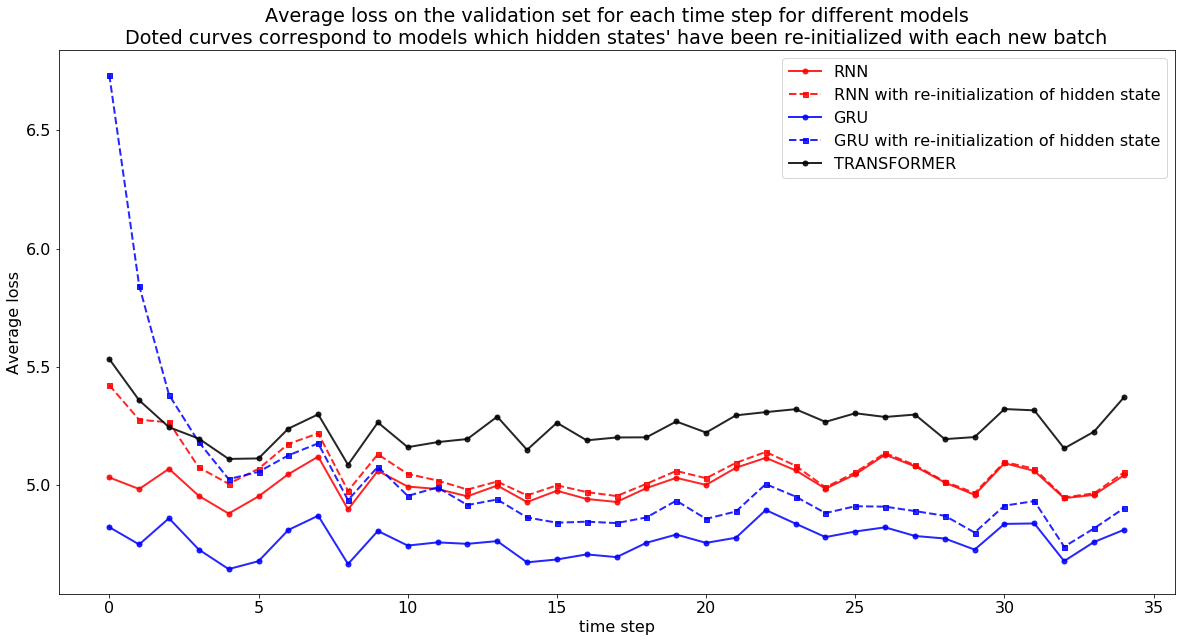

In [930]:
# plot average loss per time step
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 16})

colors = dict()
colors['RNN','norm'] = 'r'
colors['RNN','init'] = 'r'
colors['GRU','norm'] = 'b'
colors['GRU','init'] = 'b'
colors['TRANSFORMER','norm'] = 'k'

markers = dict()
markers['RNN','norm'] = '-o'
markers['RNN','init'] = '--s'
markers['GRU','norm'] = '-o'
markers['GRU','init'] = '--s'
markers['TRANSFORMER','norm'] = '-o'

xx     = np.arange( seq_len )
for i,key in enumerate( avg_errors.keys() ):
    plt.plot( xx , avg_errors[key]   , markers[key], markersize=5, linewidth=2, label=labels[key], color=colors[key] , alpha=0.85)

plt.title("Average loss on the validation set for each time step for different models\n"
          "Doted curves correspond to models which hidden states' have been re-initialized with each new batch")
plt.xlabel('time step')
plt.ylabel('Average loss')
plt.legend()
plt.show()



## Answering 5.1    
TODO    
blablabla   

# Prob 5.2

The relevant code for this problem is located in problem5.py, between the 2 comments "start of code for prob 5.2" and "end of code for prob 5.2".  

We first instantiate and load a trained model (from problem 4.1) to collect the required data. In order to initialize the hidden state of the RNN and the GRU we first run the model on few batches. After, we run the model on a batch of data collecting the gradient of the loss function for the last word of the sequence for some hidden states and for all time steps. We then compute the norm of this gradient and average it across sequences of the batch. We've define the "set_hooks" function in such a way that we can retrieve the gradient of the loss function wrt the hidden states even for the transformer, so we've included the transformer in this discussion (but in order for the code to work for the transformer, we have to add some missing fields to it such as hidden_size)

The code below runs a single model (RNN, GRU or TRANSFORMER) on the training dataset and save the results to a .npy file that can be loaded afterwards to compare the result for different architectures. 

In [420]:
# step 1 , instantiate a model.

import importlib
import problem5
importlib.reload(problem5)
import models_coop as modelsc
importlib.reload(modelsc)
import matplotlib.cm as cm

# model_type = 'RNN'
# model_type = 'GRU'
model_type = 'TRANSFORMER'

n_units      = 512
hidden_size  = 1500
emb_size     = 200
seq_len      = 35
batch_size   = 20
vocab_size   = 10000
num_layers   = 2
dp_keep_prob = 0.35
dp_prob_tran = 0.1
num_blocks   = 6

datapath  = "./from_teacher/data"
print('Loading data from '+ datapath)
raw_data = ptb_raw_data(data_path=datapath)
train_data, valid_data, test_data, word_to_id, id_2_word = raw_data
vocab_size = len(word_to_id)

if model_type == 'RNN':
    net = modelsc.RNN(emb_size=emb_size, hidden_size=hidden_size,
                seq_len=seq_len, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers,
                dp_keep_prob=dp_keep_prob)
    loading_path = "RNN_final"
    loading_path += "/best_params.pt"
    net.load_state_dict(torch.load(loading_path))
elif model_type == 'GRU':
    net = modelsc.GRU(emb_size=emb_size, hidden_size=hidden_size,
                seq_len=seq_len, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers,
                dp_keep_prob=dp_keep_prob)
    loading_path = "GRU_final"
    loading_path += "/best_params.pt"
    net.load_state_dict(torch.load(loading_path))
elif model_type == 'TRANSFORMER' :
    loading_path = "TRA_final"
    loading_path += "/best_params.pt"
    net = TRANSFORMER(vocab_size=vocab_size, n_units=n_units, n_blocks=num_blocks, dropout=dp_prob_tran)
    net.load_state_dict(torch.load(loading_path))
    net.batch_size = batch_size
    net.seq_len    = seq_len
    net.vocab_size = vocab_size
    net.hidden_size= n_units
    net.num_layers = num_blocks
else :
    pass

Loading data from ./from_teacher/data


In [421]:
# _ = net.to(device)
_ = net.cpu()

norm_avg_nablaL = problem5.code_for_52(net,model_type, train_data)
# flip left-right so that indice i means time step T-i
norm_avg_nablaL = np.fliplr(norm_avg_nablaL)

In [422]:
# SAVE GRAD
save_dir      = "prob5_save"
avg_loss_path = os.path.join(save_dir, 'norm_avg_nablaL_{model_type}.npy'.format(model_type=model_type))
np.save(avg_loss_path, {'norm_avg_nablaL':norm_avg_nablaL} )

After running the code above for all models, we can now load the collected data and comment on it.

In [903]:
# LOAD GRAD

norm_avg_nablaL = dict()
labels     = dict()
for model_ in ('RNN','GRU','TRANSFORMER') :
    lc_path  = "prob5_save"
    lc_path += "/norm_avg_nablaL_{model_}.npy".format(model_=model_)
    loaded_data_dict = np.load(lc_path)[()]
    norm_avg_nablaL[model_]  = loaded_data_dict['norm_avg_nablaL']
    labels[model_]           = "{model_}".format(model_=model_)

We can now plot the data.

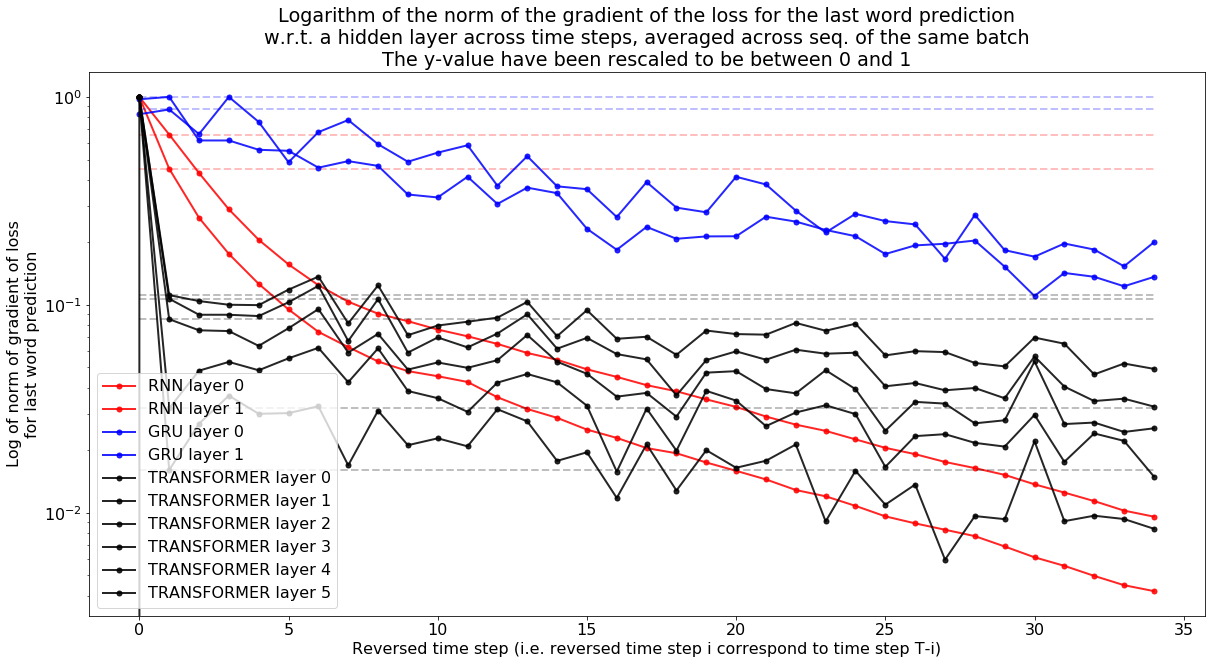

In [925]:
# plot average loss per time step

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 16})

colors = dict()
colors['RNN'] = 'r'
colors['GRU'] = 'b'
colors['TRANSFORMER'] = 'k'

xx     = np.arange( seq_len )
for i,key in enumerate( norm_avg_nablaL.keys() ):
    na_nablaL = norm_avg_nablaL[key]
    for i in range( na_nablaL.shape[0] ):
        lab = labels[key] + " layer {i}".format(i=i)
        mx = na_nablaL[i,:].max() 
        mn = na_nablaL[i,:].min() - 1.0e-5
        # na_nablaL_rescaled = ( na_nablaL[i,:] - mn ) / ( mx - mn )
        na_nablaL_rescaled = na_nablaL[i,:] / mx 
        nb_val = na_nablaL_rescaled.shape[0]
        na_nablaL_first_va = na_nablaL_rescaled[ 1 ] * np.ones( nb_val )
        plt.plot( xx[:] , na_nablaL_rescaled[:] , '-o', markersize=5, linewidth=2, label=lab, color=colors[key] , alpha=0.85)
        plt.plot( xx[:] , na_nablaL_first_va[:] , '--', markersize=5, linewidth=2,            color=colors[key] , alpha=0.25)
        
        
plt.title("Logarithm of the norm of the gradient of the loss for the last word prediction\n"
          "w.r.t. a hidden layer across time steps, averaged across seq. of the same batch\n"
          "The y-value have been rescaled to be between 0 and 1" )
plt.xlabel('Reversed time step (i.e. reversed time step i correspond to time step T-i)')
plt.ylabel('Log of norm of gradient of loss\nfor last word prediction')
plt.yscale('log')
plt.legend()
plt.show()



## Answering 5.2    
TODO    
blablabla.    

# Prob 5.3
The sampling functions for this problem are located in model.py, for both the RNN and the GRU we use a method called "generate" that takes seeds and hidden states has input and outputs the following : (sampled sequences, their log-probabilities, hidden states).

We first instantiate and load a trained model (from problem 4.1). In order to initialize the hidden state of the RNN and the GRU we first run the model on few mini-batches. After, we begin to generate samples. In the generation process we prevent the '<ukn>' token from being sampled. This is the only token we exclude. We make this choice in order to produce samples that make more sense. The seeds used to generate the samples are the last words of the previous batch. 

The models were trained with sequences of length 35. We sample for each (2) models 200 sequences of length 35 and 200 sequences of length 70. All those exemple are saved to a file.

Amongst each pack of 200 samples, we only select 10 samples equally spaced from the least probable to the more probable one.  Then for each architecture we are left with 10 short and 10 long samples. For each model we then select 3 best, 3 worst and 3 interesting samples. And comment on them.

#### First, we are showing some data to illustrate how the density looks like for the certainty of next word prediction    
We feed the transformer a sentence taken from the validation dataset and display his certainty about the next words for few words of the sentence.

In [852]:
loading_path = "./TRA_final"
loading_path += "/best_params.pt"
net = TRANSFORMER(vocab_size=10000, n_units=512, n_blocks=6, dropout=0.1)
net.load_state_dict(torch.load(loading_path))
_ = net.cpu()

In [853]:
datapath  = "./from_teacher/data"
print('Loading data from '+ datapath)
raw_data = ptb_raw_data(data_path=datapath)
train_data, valid_data, test_data, word_to_id, id_2_word = raw_data
vocab_size = len(word_to_id)
iterator = ptb_iterator(valid_data, 10, 35)

sample_sequence = ""
inputs, targets = next(iterator, None)
sample = inputs[0]
for i in sample :
    sample_sequence += id_2_word[i] + " "
# print( sample_sequence )
vocab_density = np.empty( [ 4 , vocab_size ] )

Loading data from ./from_teacher/data


In [854]:
batch = Batch( torch.from_numpy( np.asarray( sample ) ).long().unsqueeze(0).cpu() )
# batch = Batch( torch.from_numpy( np.asarray(sent_seq[2]) ).long().unsqueeze(0).to(device) )
with torch.no_grad() :
    out = net.forward( batch.data, batch.mask ).squeeze(0).detach().cpu()

vocab_density[0,:] = np.sort( out[ 1 ,:].numpy() )
vocab_density[1,:] = np.sort( out[ 5 ,:].numpy() )
vocab_density[2,:] = np.sort( out[ 10,:].numpy() )
vocab_density[3,:] = np.sort( out[ 15,:].numpy() )

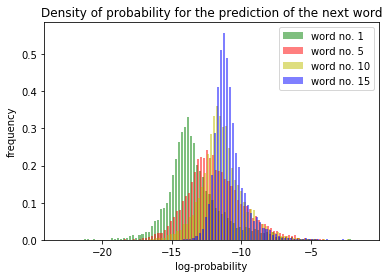

In [855]:
n_sample = vocab_density.shape[0]
dens_to_plot = []
for i in range( n_sample ):
    dens_to_plot += [vocab_density[i,:]]
colors = ['g', 'r' , 'y', 'b' ]
labels = []
for i in (1,5,10,15):
    labels += ["word no. {}".format(i)]
plt.hist( dens_to_plot , 100, density=True, rwidth=3, width = 0.15, color=colors , label=labels, alpha=0.5)
plt.title("Density of probability for the prediction of the next word")
plt.xlabel('log-probability')
plt.ylabel('frequency')
plt.legend()
plt.show()


#### Comment of the distribution   
We make the following observation : at all times, very few words are absolutely impossible, very few words are very likely, and the bulk of the distribution is a very large number of words that are quite equally likely. When we sample from this type of distribution that was obtain through a softmax we can multiply the input of the softmax by factor. We call this factor the temperature T and call the likely words the 'hot' words. By increasing T, we can increase the likeliness of the 'hot' words and by decreasing it, we can flatten the distribution and make it more probable to sample from the bulk of the distribution which is made from a large number of words that are equally probable.

This notion of temperature in the code appears in the "sample_from_logits" function that is used to sample from this kind of distribution.

#### Loading a model and running it

In [900]:
# step 1 , instantiate a model.
import importlib
import problem5
importlib.reload(problem5)
import models_coop as modelsc
importlib.reload(modelsc)
import matplotlib.cm as cm

model_type = 'RNN'
# model_type = 'GRU'

n_units      = 512
hidden_size  = 1500
emb_size     = 200
seq_len      = 35
batch_size   = 20*10
vocab_size   = 10000
num_layers   = 2
dp_keep_prob = 0.35
dp_prob_tran = 0.1
num_blocks   = 6

datapath  = "./from_teacher/data"
print('Loading data from '+ datapath)
raw_data = ptb_raw_data(data_path=datapath)
train_data, valid_data, test_data, word_to_id, id_2_word = raw_data
vocab_size = len(word_to_id)

if model_type == 'RNN':
    net = modelsc.RNN(emb_size=emb_size, hidden_size=hidden_size,
                seq_len=seq_len, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers,
                dp_keep_prob=dp_keep_prob)
    loading_path = "RNN_final"
    loading_path += "/best_params.pt"
    net.load_state_dict(torch.load(loading_path))
elif model_type == 'GRU':
    net = modelsc.GRU(emb_size=emb_size, hidden_size=hidden_size,
                seq_len=seq_len, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers,
                dp_keep_prob=dp_keep_prob)
    loading_path = "GRU_final"
    loading_path += "/best_params.pt"
    net.load_state_dict(torch.load(loading_path))
else :
    pass

generated_seq = dict()

Loading data from ./from_teacher/data


In [898]:
# take a batch of data to do prob 5.3

# _ = net.to(device)
_ = net.cpu()

iterator = ptb_iterator(train_data, net.batch_size, net.seq_len)
generated_seq_len = seq_len 
# generated_seq_len = seq_len * 2
with torch.no_grad():
    net.eval()
    hidden = net.init_hidden() #.to(device) 
    # build context for recurent models
    if model_type == 'RNN' or model_type == 'GRU':
        for _ in range(10): # we run few batches to initialize the hidden states
            x,y    = next(iterator)  
            inputs = torch.from_numpy(x.astype(np.int64)).transpose(0, 1).contiguous() #.to(device)   
            hidden = repackage_hidden(hidden)
            outputs, hidden = net(inputs, hidden)
    # now we have relevent hidden states, we can use that in order to generate new stuff
    # y is (batch_size, seq_len)
    # we take the last slice of data and use it as seed for the generation
    inputs           = torch.from_numpy(y[:,-1].astype(np.int64)) #.to(device) 
    samples, probs, hidden  = net.generate(inputs, hidden, generated_seq_len)
    # samples is (generated_seq_len,batch_size)
    samples = samples.transpose(0,1).contiguous().cpu().numpy()
    for i in range( net.batch_size ) :
        generated_seq[generated_seq_len,i] = [probs[i], samples[i]]


In [899]:
# take a look at some generated sequences
def print_seq(array_of_id):
    n = len(array_of_id)
    print(  "\n############################\n")
    for i in range(n):
        w = id_2_word[ array_of_id[i] ]
        if w == '<eos>' :
            w = '\n'
        print( w , end=" ")
    print("\n\n############################\n")

sorted_index = probs.sort()[1]
limit        = 10
ind          = np.empty(limit,dtype=int)
pro          = np.empty(limit,dtype=float)
spacing = batch_size//limit
for i in range(limit):
    ind[i] = sorted_index[ i * spacing + spacing//2 ]
    pro[i] = probs[ ind[i] ]
# preview 10 sequences ranging from the most to the least probable
for i,p in zip(ind,pro):
    print( "Pr = exp( {:3.1f} )".format( p.item() ) )
    print_seq( samples[ i , : ] )

Pr = exp( -195.6 )

############################

provide colleges to cause favor enough for the case of the government but american new design chemical and the atmosphere of cash beyond the companies shipbuilding foot for error that the cowboys can be able 

############################

Pr = exp( -174.3 )

############################

the engelken are about part of a N that should be a or equal pulls the new market papers 
 to N the student commission ca n't help of its ideas in the including three 

############################

Pr = exp( -170.3 )

############################

earnings in our market and the same long-term growth more than and 
 they try 
 diversified the new optical strategy was able to maintain that 's independence to soviet senior including mr. lawson 
 

############################

Pr = exp( -164.0 )

############################

years later 
 the white house canada also has resisted an additional strategic action from filings he wants to more the capacity o

In [887]:
# SAVE SAMPLED SEQUENCES
save_dir      = "prob5_save"
avg_loss_path = os.path.join(save_dir, 'generated_seq_{model_type}.npy'.format(model_type=model_type))
np.save(avg_loss_path, {'generated_seq':generated_seq} )

In [888]:
# LOAD SAMPLES SEQUENCES
load_gen_seq = dict()
load_gen_seq['RNN','short'] = dict()
load_gen_seq['RNN','long']  = dict()
load_gen_seq['GRU','short'] = dict()
load_gen_seq['GRU','long']  = dict()

for model_ in ('RNN','GRU') :
    lc_path  = "prob5_save"
    lc_path += '/generated_seq_{model_}.npy'.format(model_=model_)
    corresp = {35 : 'short', 70 : 'long'}
    loaded_data_dict = np.load(lc_path)[()]
    for k,v in loaded_data_dict['generated_seq'].items() :
        load_gen_seq[model_, corresp[ k[0] ] ][ k[1] ] = v


In [901]:
# TAKE 10 SAMPLED SEQUENCE FOR EACH MODEL AND EACH LENGTH
import operator

# take a look at generated sequences
def print_seq_and_prob(num ,array_of_id, p):
    n = len(array_of_id)
    print(  "\n#### sample no. {} ####".format(num) , end=" ")
    print( "Pr = exp( {:3.1f} )".format( p ) )
    for i in range(n):
        w = id_2_word[ array_of_id[i] ]
        if w == '<eos>' :
            w = '\n'
        print( w , end=" ")
    print("\n")
    
limit     = 10
n_samples = 200
num       = 0
for (model_,length),sequences in load_gen_seq.items():
    print(model_ , length, "sequences : ")
    sorted_sequences = sorted(sequences.items(), key=operator.itemgetter(1))
    ind = np.linspace(0, n_samples-1, num=limit, endpoint=True, dtype=int)
    for i in ind :
        num += 1
        p = sorted_sequences[i][1][0].item()
        print_seq_and_prob( num, sorted_sequences[i][1][1] , p)
    

RNN short sequences : 

#### sample no. 1 #### Pr = exp( -137.3 )
a huge N of its computer system and foreign governments and its loans ' loans of oppose the u.s. and environmental relief 
 the justice department can make these projects are the u.s. 
 the 


#### sample no. 2 #### Pr = exp( -117.5 )
initiatives 
 the move are a military approach to be prepared to be clearly 
 the measure bill would be introduced in the policy and the government 
 the state has opposed to discuss the 


#### sample no. 3 #### Pr = exp( -110.0 )
and use of the short term 
 the market 's N and chief executive officer of the bank and other east german offerings under the american government 
 east germany 
 the u.s. trade commission 


#### sample no. 4 #### Pr = exp( -106.8 )
in the nfl and the house was never to be a good sign that he would n't be able to make more better than a management 
 the the bill is abc and it has 


#### sample no. 5 #### Pr = exp( -103.5 )

 the white house is the movement of t

## Answering 5.3   

TODO

#### RNN :    
Best        : samples no.    ...    
Interesting : samples no.    ...    
Worst       : samples no.    ...    

#### GRU :
Best        : samples no.    ...   
Interesting : samples no.    ...    
Worst       : samples no.    ...    

blablabla

#### Extra code : sampling from the transformer   
The following code can be used to sample from the transformer. It includes 2 sampling algorithm that only use the model in black-box to sample from it. There is a greedy-beam-search with random sampling algorithm and a truncated-sampler that sample at each step only from the most probable next words.

In [28]:
class SamplerNode:
    # contains sequence of words and the associated probability
    def __init__(self, seq, pro):
        self.seq = seq
        self.pro = pro
    
    def get_values(self):
        return self.seq, self.pro
    
    # define 'lower than' operator
    # comparison is made according to probabilities, not sequences
    def __lt__(self, other):
        return self.pro > other.pro 
    
    # define equality operator, comparison is made according to sequences
    def __eq__(self, other):
        return self.seq == other.seq
    
    def __hash__(self):
        return hash(tuple(self.seq))
    
class BeamSampler:
    # greedy search
    # 'beam_size' is an int (e.g. 5)
    # at each step, search 'beam_size' new child for each current nodes 
    # then pick the 'beam_size' best amongst them
    # repeat until a sequence of desired length has been generated
    
    def __init__(self, net, length, beam_size, trim_size, outp_size, seed, id_2_word, word_to_id) :
        self.net       = net 
        self.length    = length
        self.seed_id   = word_to_id.get(seed)
        self.id_2_word = id_2_word
        self.word_to_id= word_to_id
        self.nodes     = []
        
        self.beam_size = beam_size
        self.trim_size = trim_size
        self.outp_size = outp_size
        
        self.unkn_id = word_to_id['<unk>']
        self.stop_id = word_to_id['<eos>']
        
    def generate_sequence(self):
        
        with torch.no_grad():
            # first step : sample from seed
            self.gen_first_nodes_from_seed()

            # all subsequent step : sample from nodes
            # we have already generated 2 words by now
            for i in range(2,self.length):
                # self.print_nodes()
                self.next_step()
                # trim from time to time, but not close to the end
                if i%5 == 0 and i < self.length - 5 :
                    self.trim_keep_rand()
                    self.remove_redundant_nodes()
            else : # only keep the best
                self.remove_redundant_nodes()
                self.trim_keep_best()
    
    def print_nodes(self):
        # pick the best node
        for i, node in enumerate(sorted(self.nodes)):
            seq, prob = node.get_values()
            print( "node no." , i , " , prob = " , prob , " : \n" )
            print( self.id_seq_2_word_seq(seq) )
    
    def print_readable_nodes(self):
        for i, node in enumerate(sorted(self.nodes)):
            seq, prob = node.get_values()
            print( "\n********************************************\n")
            print( "node no." , i , " , prob = " , prob , " : \n" )
            for word in seq :
                print( self.id_2_word.get(word) , end= " ")
            print( "\n*********************************************\n")
            
    def id_seq_2_word_seq(self, id_seq):
        return [ self.id_2_word.get( i ) for i in id_seq ]
        
    def next_step(self):
        # generete next word suggestion for all current nodes
        # and pick the best amongst them to form the next layer
        # of nodes
        bs              = self.beam_size
        n_node          = len( self.nodes )
        next_nodes      = []
        best_next_nodes = []
        next_nodes_prob = torch.zeros( n_node , bs , dtype=torch.float)
        
        for i,n in enumerate(self.nodes):
            seq, pro = n.get_values()
            next_words, probs = self.sample(seq)
            for j,nw in enumerate(next_words):
                # reject next word suggestion if it has the '<unk>' label
                if nw != self.unkn_id :
                    this_node = seq + [nw.item()] 
                    this_prob = pro + probs[j].item()
                else : 
                    continue
                
                n = SamplerNode( this_node , this_prob )
                best_next_nodes += [n]
                
        self.nodes = best_next_nodes
    
    def trim_keep_best(self):
        os              = self.outp_size
        best_next_nodes = []
        n_nodes  = len( self.nodes )
        logprob = torch.empty( n_nodes )
        for i in range(n_nodes) :
            _, logprob[i] = self.nodes[i].get_values()
            
        values, indices = torch.topk(logprob, os, dim=0)
        for i in indices :
            best_next_nodes += [ self.nodes[i] ]
            
        self.nodes = best_next_nodes
   
    def pick_some_from(self, qt, log_prob_array):
        # qt : number of element to pick randomly with repetition
        # log_prob_array : array of log probabilities
        min_val        = log_prob_array.min()
        log_prob_array = (log_prob_array-2*min_val).abs().sqrt()
        sqr_sum        = log_prob_array.sum()
        log_prob_array = log_prob_array / sqr_sum
        cumulative_dis = torch.cumsum(log_prob_array, dim=0).numpy()
        
        unif_vect = torch.FloatTensor(qt).uniform_(0,1)
        rand_ind  = np.empty(qt, dtype=int) 
        for i in range(qt):
            rand_ind[i] = np.searchsorted(cumulative_dis, unif_vect[i].item() , side='left')
            
        return rand_ind
        
    def trim_keep_rand(self):
        ts              = self.trim_size
        best_next_nodes = []
        n_nodes  = len( self.nodes )
        logprob = torch.empty( n_nodes )
        for i in range(n_nodes) :
            _, logprob[i] = self.nodes[i].get_values()
            
        indices = self.pick_some_from(ts, logprob)
        for i in indices :
            best_next_nodes += [ self.nodes[i] ]
            
        self.nodes = best_next_nodes
        
    def remove_redundant_nodes(self):
        # remove identical nodes 
        # usefull if the current set of nodes as been picked
        # randomly with repetition from another set of nodes
        tmp_set = set()
        for n in self.nodes :
            tmp_set.add(n)
        self.nodes = list( tmp_set )
    
    def prob_dist_from_seq(self, seq) :
        # for transformer :
        batch  = Batch( torch.from_numpy( np.asarray( seq ) ).long().unsqueeze(0).to(device) )
        y = self.net.forward( batch.data, batch.mask )[0,-1,:].cpu()
        return y
        # for the other models :
        # ...
        
    def initialize(self):
        self.nodes = []
        
    def gen_first_nodes_from_seed(self):
        self.initialize()
        y = self.prob_dist_from_seq( [self.seed_id] )
        probs , top_id = torch.topk(y, self.beam_size + 1, dim=-1)
        
        for i,j in enumerate(top_id) :
            if j.item() == self.unkn_id : # exclude '<unk>' label
                continue
            if len(self.nodes) >= self.beam_size : # 
                break
            n = SamplerNode( [self.seed_id, j.item()] , probs[i] )
            self.nodes += [n]
            
    def sample(self, node):
        # return self.beam_size (e.g. 3) suggestions for the next word, 
        # given node as current sequence
        with torch.no_grad() :
            y = self.prob_dist_from_seq(node)
            probs , top_id = torch.topk(y, self.beam_size, dim=-1)
            
        # the model return log probabilities, we convert them to real prob by applying exp.
        return top_id , probs
        

In [32]:
seed      = '<eos>'
beam_size = 3   # number of nodes to explore at each step
trim_size = 10  # number of nodes picked at random with repetition during trimming
outp_size = 20  # number of nodes to keep at the end
length    = 70  # length of the output sentence, measured by the number of token (i.e. words)

bsampler = BeamSampler( net.to(device) , length, beam_size, trim_size, outp_size, seed, id_2_word, word_to_id )

In [207]:
%%timeit -c -n 1 -r 1

bsampler.generate_sequence()
bsampler.print_readable_nodes()


********************************************

node no. 0  , prob =  tensor(-144.7765)  : 

<eos> mr. icahn has n't disclosed <eos> mr. icahn is expected to take more of his usx executives on his plan and mr. corry would have to pay his company <eos> but mr. corry has been executive vice president and chief operating officer in his concern in his company <eos> mr. icahn chairman and chief financial officer said he said it has agreed to buy more than $ N million 
*********************************************


********************************************

node no. 1  , prob =  tensor(-145.6540)  : 

<eos> mr. icahn has n't disclosed <eos> mr. icahn is expected to take more of his usx executives on his plan and mr. corry would have to pay his company <eos> but mr. corry has been executive vice president and chief operating officer in his concern in his company <eos> mr. icahn chairman and chief financial officer said he said it would n't resigned as a chief executive vice chairman 
*****

### Approximation of a true sampler :

In [33]:
class TrueSampler:
    # output a random sequence of fixed lenght by sampling each consecutive
    # word from true distribution truncated to the most probable suggestions
    # trunc_search : nb of most probable suggestions we sample from at each step
    
    def __init__(self, net, length, trunc_search, seed, id_2_word, word_to_id) :
        self.net          = net 
        self.length       = length
        self.id_2_word    = id_2_word
        self.word_to_id   = word_to_id
        self.trunc_search = trunc_search
        self.initialize()
        
        self.real_pro   = 0
        self.trun_pro   = 0
        
        self.unkn_id = word_to_id['<unk>']

    def generate_sequence(self):
        with torch.no_grad():
            # all step : sample from current seq
            for i in range(1,self.length):
                self.next_step()
    
    def print_readable(self):
        seq = self.sequence
        print( "\n********************************************\n")
        print( "current node, real prob = " , self.real_pro.item() , "truncated prob = " , self.trun_pro.item() , " : \n" )
        for word in seq :
            print( self.id_2_word.get(word) , end= " ")
        print( "\n*********************************************\n")
        
    def next_step(self):
        # generete next word suggestion for current node
        seq       = self.sequence
        next_word = self.sample(seq)
        self.sequence += [next_word]
   
    def pick_one_from(self, log_prob_array):
        # pick one element randomly from :
        # log_prob_array : array of log probabilities
        max_val        = log_prob_array.max()
        log_prob_array = (log_prob_array-max_val).exp()  # adjust scaling
        pro_sum        = log_prob_array.sum()
        log_prob_array = log_prob_array / pro_sum
        cumulative_dis = torch.cumsum(log_prob_array, dim=0).numpy()
        
        unif_01  = torch.FloatTensor(1).uniform_(0,1)
        rand_ind = np.searchsorted(cumulative_dis, unif_01.item() , side='left')
            
        return rand_ind, log_prob_array[rand_ind].log()
    
    def prob_dist_from_seq(self, seq) :
        # for transformer :
        batch  = Batch( torch.from_numpy( np.asarray( seq ) ).long().unsqueeze(0).to(device) )
        y = self.net.forward( batch.data, batch.mask )[0,-1,:].cpu()
        return y
        # for the other models :
        # ...
        
    def initialize(self):
        self.sequence   = [ word_to_id[seed] ]
            
    def sample(self, node): 
        # sample, but exclude '<unk>' id
        y = self.prob_dist_from_seq(node)
        probs , top_id = torch.topk(y, self.trunc_search, dim=-1)
        
        next_id = self.unkn_id
        while next_id == self.unkn_id :
            rand_ind, trunc_prob = self.pick_one_from( probs )
            next_id = top_id[rand_ind].item()
            
        # update (true and truncated) probability of the current sequence
        self.real_pro += probs[rand_ind]
        self.trun_pro += trunc_prob
        
        return next_id
        

In [20]:
seed      = '<eos>'
trunc_search = 100   # number of nodes to explore at each step
length       = 10  # length of the output sentence, measured by the number of token (i.e. words)

net.eval()
tsampler = TrueSampler( net.to(device) , length, trunc_search, seed, id_2_word, word_to_id )

NameError: name 'net' is not defined

In [250]:
%%timeit -c -n 1 -r 1
tsampler.initialize()
tsampler.generate_sequence()
tsampler.print_readable()


********************************************

current node, real prob =  -52.9013671875 truncated prob =  -49.030029296875  : 

<eos> he said he believes of new rules on a 
*********************************************

386 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
